In [84]:
import contextlib
import io

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Bidirectional, GRU

In [2]:
# Températures, Humidité
Temp_HR = ['N1NTemp', 'N1ETemp', 'N1STemp', 'N1OTemp', 'S1NTemp', 'S1OTemp', 'N2STemp', 'N2OTemp', 'N2ETemp', 'N2NTemp', 'S2STemp', 'S2OTemp', 'S2ETemp', 'S2NTemp', 'N2SHR', 'N2OHR', 'N2EHR', 'N2NHR', 'S2SHR', 'S2OHR', 'S2EHR', 'S2NHR']

# Humidité, Températures (Tour Nord 2 Etages)
tour_nord_2_temp_HR = [("N2STemp", "N2SHR"), ("N2OTemp", "N2OHR"), ("N2ETemp", "N2EHR"), ("N2NTemp", "N2NHR")]
tour_sud_2_temp_HR = [("S2STemp", "S2SHR"), ("S2OTemp", "S2OHR"), ("S2ETemp", "S2EHR"), ("S2NTemp", "S2NHR")]

In [3]:
def split_dataframe(df, train_size=0.7, val_size=0.2):
    """
    Découpe un DataFrame temporel en trois parties : train, val, test,
    en respectant l'ordre chronologique.

    Args:
        df (pd.DataFrame): Données à découper (indexé ou non par le temps)
        train_size (float): Proportion pour l'ensemble d'entraînement
        val_size (float): Proportion pour la validation

    Returns:
        df_train, df_val, df_test (DataFrames)
    """
    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]

    print(f"Train size : {len(df_train)}")
    print(f"Val size : {len(df_val)}")
    print(f"Test size : {len(df_test)}")

    return df_train.copy(), df_val.copy(), df_test.copy()

In [75]:
def evaluate_model(y_true, y_pred):
    """
    Calcule et affiche les métriques MAE, RMSE et R² entre les vraies valeurs et les prédictions.

    Args:
        y_true (array-like): Valeurs réelles.
        y_pred (array-like): Valeurs prédites.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')
    
    return mae, rmse, r2

In [5]:
def create_dataset(X, y, time_steps=1):  
    Xs, ys = [], []   
    for i in range(len(X) - time_steps):   
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)      
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

    """
This function prepares the input features and target values in the format required for training a recurrent neural network (RNN) or LSTM model for sequential prediction tasks. It creates sequences of input features and their corresponding target values, which can be fed into the model during training.

    - X: This parameter represents the input features, typically a pandas DataFrame containing multiple time-series variables such as temperature, humidity, etc.
    - y: This parameter represents the target values, which are typically the values we want to predict based on the input features.
    - time_steps: This parameter defines the length of each sequence. It determines how many data points from the past will be used to predict the next data point. For example, if time_steps is set to 3, the function will create sequences of three consecutive data points as input features and the next data point as the target value.
    """

In [6]:
def build_and_train_bilstm(X_train, y_train, X_val, y_val, sequence_length, units=100, 
                           activation='tanh', epochs=30, batch_size=32, patience=10):
    """
    Construit, entraîne et évalue un modèle BiLSTM avec early stopping.

    Args:
        X_train (ndarray): Données d'entraînement (3D).
        y_train (ndarray): Cibles d'entraînement.
        X_val (ndarray): Données de validation (3D).
        y_val (ndarray): Cibles de validation.
        sequence_length (int): Longueur des séquences en entrée.
        units (int): Nombre de neurones dans la couche LSTM.
        activation (str): Fonction d'activation de la couche LSTM.
        epochs (int): Nombre d’époques d’entraînement.
        batch_size (int): Taille de lot pour l’entraînement.
        patience (int): Patience pour l’early stopping.

    Returns:
        model: Le modèle entraîné.
        history: L'historique d'entraînement.
        val_loss: La perte de validation finale.
    """
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation=activation, input_shape=(sequence_length, X_train.shape[2]))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    val_loss = model.evaluate(X_val, y_val, verbose=0)
    display(f'Validation Loss: {val_loss}')

    return model, history, val_loss

In [7]:
def load_data_drias(path_fichier_excel):
    """
    Charge un fichier Excel DRIAS avec une colonne 'Date' au format '%d/%m/%Y',
    et retourne un DataFrame avec la date en index.

    Args:
        path_fichier_excel (str): Chemin vers le fichier Excel.

    Returns:
        pd.DataFrame: Données DRIAS avec l'index daté.
    """
    df = pd.read_excel(path_fichier_excel)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df.set_index('Date', inplace=True)
    display(df.tail())
    return df

In [8]:
def predict_and_inverse_transform(model, X, y, target_transformer):
    """
    Effectue la prédiction avec le modèle donné et applique l'inverse de la transformation 
    sur les prédictions et les vraies valeurs cibles.

    Args:
        model: Modèle entraîné (ex. BiLSTM).
        X_val: Données d'entrée de validation.
        y_val: Vraies valeurs cibles de validation.
        target_transformer: Transformateur utilisé pour normaliser les cibles (ex. MinMaxScaler).

    Returns:
        Tuple (y_pred_original_scale, y_true_original_scale)
    """
    # Prédiction
    y_pred = model.predict(X)

    # Inversion de la transformation des prédictions
    y_pred_inv = target_transformer.inverse_transform(y_pred)

    # Reshape puis inversion de la transformation des vraies valeurs
    y = y.reshape(-1, 1)
    y_val_inv = target_transformer.inverse_transform(y)

    return y_pred_inv, y_val_inv

In [73]:
def temp_mean_max_min(data1, data2, data_designatin_1, data_designatin_2):
    
    # Liste des années à importer
    annees = range(2006, 2026)

    # Nombre de subplots nécessaires
    cols = 2  # Nombre de colonnes
    rows = len(annees) # Nombre de lignes

    i = 1
    
    #Initialiser le graphique
    plt.figure(figsize=(cols*14,rows*7))
    
    for idx, annee in enumerate(annees):
        

        plt.subplot(rows, cols, i)
        # Filtrer les données de l'année
        data2_df_annee = data2[data2.index.year == annee].copy()

        # Remplacer l'année dans les dates par 2000 pour superposition
        data2_df_annee.index = data2_df_annee.index.map(lambda d: d.replace(year=2000))

        # Tracer la température moyenne avec une couleur unique par année
        data2_df_annee["2m_Temperature_C"].plot(
            label=f"Temp Moyenne {annee}",
            color="blue",
            lw=2
        )

        """  # Tracer la température maximale avec une couleur unique par année
        data2_df_annee["MAX_TEMPERATURE_C"].plot(
            label=f"Temp Maximale {annee}",
            color="red",
            lw=2
        )

        # Tracer la température minimale avec une couleur unique par année
        data2_df_annee["MIN_TEMPERATURE_C"].plot(
            label=f"Temp minimale {annee}",
            color="green",
            lw=2
        )
        """
        # Configuration de l'axe des X pour n’afficher que les mois
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.
        plt.xlabel("Date")
        plt.ylabel("Température (°C)")
        plt.title(f"{data_designatin_1} : {annee}")
        plt.ylim(-10, 40)  # Limites pour l'axe Y
        plt.legend()
        plt.grid()

        plt.subplot(rows, cols, i+1)
        # Filtrer les données de l'année
        data1_df_annee = data1[data1.index.year == annee].copy()

        # Remplacer l'année dans les dates par 2000 pour superposition
        data1_df_annee.index = data1_df_annee.index.map(lambda d: d.replace(year=2000))

        # Tracer la température moyenne avec une couleur unique par année
        data1_df_annee["tasAdjust"].plot(
            label=f"Temp Moyenne {annee}",
            color="blue",
            lw=2
        )

        """ # Tracer la température maximale avec une couleur unique par année
        data1_df_annee["tasmaxAdjust"].plot(
            label=f"Temp Maximale {annee}",
            color="red",
            lw=2
        )

        # Tracer la température minimale avec une couleur unique par année
        data1_df_annee["tasminAdjust"].plot(
            label=f"Temp minimale {annee}",
            color="green",
            lw=2
        ) """
        # Configuration de l'axe des X pour n’afficher que les mois
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.
        plt.xlabel("Date")
        plt.ylabel("Température (°C)")
        plt.title(f"{data_designatin_2} : {annee}")
        plt.ylim(-10, 40)
        plt.legend()
        plt.grid()

        i = i + 2
        
    # Afficher le graphique
    plt.show()

#### **Dataset DRIAS RCP**

In [11]:
data_rcp_2_6 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp2.6_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2100-12-27,49.2427,4.03882,0.67,4.61,2.63,0.000,0.000,3.508,53.907,263.422,12.37,0.591
2100-12-28,49.2427,4.03882,-0.74,2.53,0.72,1.015,0.644,3.386,12.878,314.804,13.65,0.432
2100-12-29,49.2427,4.03882,-1.10,1.20,-0.24,0.381,0.381,3.521,18.212,310.789,4.29,0.185
2100-12-30,49.2427,4.03882,-3.13,0.07,-1.50,0.069,0.000,2.961,11.396,312.622,5.85,0.196
2100-12-31,49.2427,4.03882,-1.72,2.36,0.88,0.192,0.091,3.459,31.068,300.079,5.88,0.183


In [12]:
data_rcp_4_5 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp4.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2100-12-27,49.2427,4.03882,1.00,9.48,4.55,0.000,0.0,4.967,51.618,286.619,11.37,0.200
2100-12-28,49.2427,4.03882,4.14,11.98,8.26,3.633,0.0,5.910,38.051,318.954,14.50,0.370
2100-12-29,49.2427,4.03882,4.61,9.58,8.07,2.746,0.0,5.180,30.541,324.057,15.67,0.614
2100-12-30,49.2427,4.03882,6.15,10.11,7.57,9.368,0.0,5.884,17.554,334.634,36.97,0.764
2100-12-31,49.2427,4.03882,5.40,6.59,6.08,2.348,0.0,5.043,15.093,337.720,18.19,0.618


In [13]:
data_rcp_8_5 = load_data_drias('Drias/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp8.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')

,Latitude,Longitude,tasminAdjust,tasmaxAdjust,tasAdjust,prtotAdjust,prsnAdjust,hussAdjust,rsdsAdjust,rldsAdjust,sfcWindAdjust,evspsblpotAdjust
Date,,,,,,,,,,,,
2100-12-27,49.2427,4.03882,-0.66,6.08,1.58,0.070,0.000,3.103,51.761,285.622,7.58,0.496
2100-12-28,49.2427,4.03882,1.82,4.38,3.04,0.265,0.000,4.683,21.316,340.201,1.68,0.139
2100-12-29,49.2427,4.03882,2.17,6.72,5.15,0.463,0.136,4.927,17.369,342.966,8.96,0.158
2100-12-30,49.2427,4.03882,5.94,8.88,7.38,0.088,0.000,5.873,11.491,356.660,15.39,0.380
2100-12-31,49.2427,4.03882,6.48,9.47,8.05,4.551,0.000,6.147,11.166,358.290,31.71,0.480


#### **Dataset Historique-Météo** 

In [29]:
# Liste des années à importer
annees = range(2009, 2026)

# Liste pour stocker les DataFrames
dfs = []

# Boucle sur les années
for annee in annees:
    nom_fichier = f"Historique-Météo/export-reims{annee}.csv"
    df = pd.read_csv(nom_fichier, skiprows=3)
    dfs.append(df)

# Concatène tous les DataFrames en un seul
data_climate_reims_2009_2025 = pd.concat(dfs, ignore_index=True)

In [30]:
data_climate_reims_2009_2025['DATE'] = pd.to_datetime(data_climate_reims_2009_2025['DATE'], format='%Y-%m-%d')
data_climate_reims_2009_2025.set_index('DATE', inplace=True)
data_climate_reims_2009_2025.head()

,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C_6H,TEMPERATURE_NOON_C_12H,TEMPERATURE_EVENING_C_18H,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,...,TEMPERATURE_NIGHT_C_3H,WEATHER_CODE_NIGHT_3H,TEMPERATURE_9H,WEATHER_CODE_9H,TEMPERATURE_15H,WEATHER_CODE_15H,TEMPERATURE_21H,WEATHER_CODE_21H,TEMPERATURE_MIDNIGHT_0H,WEATHER_CODE_MIDNIGHT_0H
DATE,,,,,,,,,,,,,,,,,,,,,
2009-01-01,3,-4,8,-3,3,-3,0.0,95,7.00,1029,...,-3,143,-2,113,0,116,-4,113,-3,143
2009-01-02,1,-5,15,-5,1,-2,0.0,88,10.00,1028,...,-5,113,-4,113,0,113,-2,116,-5,113
2009-01-03,1,-5,14,-4,1,-4,0.0,93,10.00,1028,...,-3,116,-3,113,-1,113,-5,113,-3,116
2009-01-04,-1,-6,8,-6,-1,-4,0.0,68,10.00,1026,...,-6,116,-5,113,-3,119,-4,116,-6,113
2009-01-05,-1,-4,10,-4,-1,-2,2.5,83,3.75,1021,...,-4,338,-3,332,-1,338,-2,332,-4,119


In [16]:
# MEAN_TEMPERATURE_C
colonnes_temp_horaires = [
    'TEMPERATURE_MORNING_C_6H',
    'TEMPERATURE_NOON_C_12H',
    'TEMPERATURE_EVENING_C_18H',
    'TEMPERATURE_NIGHT_C_3H',
    'TEMPERATURE_9H',
    'TEMPERATURE_15H',
    'TEMPERATURE_21H',
    'TEMPERATURE_MIDNIGHT_0H'
]

# Calcul de la moyenne journalière basée uniquement sur les températures horaires
data_climate_reims_2009_2025['MEAN_TEMPERATURE_C'] = data_climate_reims_2009_2025[colonnes_temp_horaires].mean(axis=1)
data_climate_reims_2009_2025['MEAN_TEMPERATURE_C']

DATE
2009-01-01    -1.875
2009-01-02    -2.750
2009-01-03    -2.750
2009-01-04    -4.375
2009-01-05    -2.625
               ...  
2025-04-26    11.875
2025-04-27    14.250
2025-04-28    14.500
2025-04-29    14.750
2025-04-30    15.750
Name: MEAN_TEMPERATURE_C, Length: 5964, dtype: float64

In [33]:
# récupérer les index communs data rcp2.6
common_index_data_rcp_2_6 = data_rcp_2_6.index.intersection(data_climate_reims_2009_2025.index)
data_rcp_2_6_2009_2025 = data_rcp_2_6.loc[common_index_data_rcp_2_6]

In [35]:
# récupérer les index communs data rcp4.5
common_index_data_rcp_4_5 = data_rcp_4_5.index.intersection(data_climate_reims_2009_2025.index)
data_rcp_4_5_2009_2025 = data_rcp_4_5.loc[common_index_data_rcp_4_5]

In [36]:
# récupérer les index communs data rcp8.5
common_index_data_rcp_8_5 = data_rcp_8_5.index.intersection(data_climate_reims_2009_2025.index)
data_rcp_8_5_2009_2025 = data_rcp_8_5.loc[common_index_data_rcp_8_5]

#### **Dataset Prunay**

##### **🌦️ Description des colonnes - Station météo Reims - Prunay**

signification de chaque variable issue des données météorologiques :

| **Nom de la colonne**             | **Description**                                                                 | **Unité**                   |
|----------------------------------|----------------------------------------------------------------------------------|-----------------------------|
| `time`                           | Horodatage des mesures                                                           | Date/Heure (ISO 8601)       |
| `10m-U_wind_ms`                  | Composante est-ouest du vent à 10 mètres                                        | m/s                         |
| `10m-V_wind_ms`                  | Composante nord-sud du vent à 10 mètres                                         | m/s                         |
| `2m_DewPoint_Temperature_K`      | Température du point de rosée à 2 mètres                                        | Kelvin (K)                  |
| `2m_Temperature_K`               | Température de l'air à 2 mètres                                                 | Kelvin (K)                  |
| `Surface_Pressure_Pa`           | Pression atmosphérique au niveau de la surface                                  | Pascals (Pa)                |
| `RH`                             | Humidité relative de l'air                                                       | Pourcentage (%)             |
| `Wind_Speed`                     | Vitesse du vent calculée à partir des composantes U et V                        | m/s                         |
| `Wind_Direction_CMEMS`           | Direction du vent (d'origine) selon les données CMEMS                           | Degrés (°)                  |
| `Wind_Direction_Charbel`         | Direction du vent selon un calcul propre (ex. méthode "Charbel")                | Degrés (°)                  |
| `Wind_Direction_Era5`            | Direction du vent selon les données ERA5 (réanalyse ECMWF)                      | Degrés (°)                  |



In [39]:
data_prunay = pd.read_csv('Atmo\donnees_Celine_LJ.csv')
data_prunay.head()

,time,latitude,longitude,10m-U_wind_ms,10m-V_wind_ms,2m_DewPoint_Temperature_K,2m_Temperature_K,Surface_Pressure_Pa,RH,Wind_Speed,Wind_Direction_CMEMS,Wind_Direction_Charbel,Wind_Direction_Era5
0,2006-01-01 00:00:00,49.24,4.04,3.134243,3.244023,275.30566,276.48438,98688.500,98.142507,4.510783,224.013944,225.986056,224.013944
1,2006-01-01 01:00:00,49.24,4.04,3.309480,3.341477,275.23462,276.61914,98683.940,97.822016,4.702991,224.724353,225.275647,224.724353
2,2006-01-01 02:00:00,49.24,4.04,3.143404,3.604999,275.22950,276.68042,98711.625,97.719006,4.782992,221.087024,228.912976,221.087024
3,2006-01-01 03:00:00,49.24,4.04,2.849324,3.933670,274.98290,276.33423,98712.940,97.871491,4.857202,215.917410,234.082590,215.917410
4,2006-01-01 04:00:00,49.24,4.04,2.640510,4.301672,275.22095,276.55884,98708.875,97.894295,5.047442,211.542989,238.457011,211.542989


In [40]:
data_prunay.dtypes

time                          object
latitude                     float64
longitude                    float64
10m-U_wind_ms                float64
10m-V_wind_ms                float64
2m_DewPoint_Temperature_K    float64
2m_Temperature_K             float64
Surface_Pressure_Pa          float64
RH                           float64
Wind_Speed                   float64
Wind_Direction_CMEMS         float64
Wind_Direction_Charbel       float64
Wind_Direction_Era5          float64
dtype: object

In [41]:
data_prunay['time'] = pd.to_datetime(data_prunay['time'], format='%Y-%m-%d %H:%M:%S')
data_prunay.set_index('time', inplace=True)
data_prunay.head()

,latitude,longitude,10m-U_wind_ms,10m-V_wind_ms,2m_DewPoint_Temperature_K,2m_Temperature_K,Surface_Pressure_Pa,RH,Wind_Speed,Wind_Direction_CMEMS,Wind_Direction_Charbel,Wind_Direction_Era5
time,,,,,,,,,,,,
2006-01-01 00:00:00,49.24,4.04,3.134243,3.244023,275.30566,276.48438,98688.500,98.142507,4.510783,224.013944,225.986056,224.013944
2006-01-01 01:00:00,49.24,4.04,3.309480,3.341477,275.23462,276.61914,98683.940,97.822016,4.702991,224.724353,225.275647,224.724353
2006-01-01 02:00:00,49.24,4.04,3.143404,3.604999,275.22950,276.68042,98711.625,97.719006,4.782992,221.087024,228.912976,221.087024
2006-01-01 03:00:00,49.24,4.04,2.849324,3.933670,274.98290,276.33423,98712.940,97.871491,4.857202,215.917410,234.082590,215.917410
2006-01-01 04:00:00,49.24,4.04,2.640510,4.301672,275.22095,276.55884,98708.875,97.894295,5.047442,211.542989,238.457011,211.542989


In [42]:
# récupérer les index communs data rcp2.6
common_index_data_rcp_2_6 = data_rcp_2_6.index.intersection(data_prunay.index)
data_rcp_2_6_ = data_rcp_2_6.loc[common_index_data_rcp_2_6]

In [45]:
# récupérer les index communs data rcp4.5
common_index_data_rcp_4_5 = data_rcp_4_5.index.intersection(data_prunay.index)
data_rcp_4_5_ = data_rcp_4_5.loc[common_index_data_rcp_4_5]

In [46]:
# récupérer les index communs data rcp8.5
common_index_data_rcp_8_5 = data_rcp_8_5.index.intersection(data_prunay.index)
data_rcp_8_5_ = data_rcp_8_5.loc[common_index_data_rcp_8_5]

In [51]:
data_prunay.drop(['latitude', 'longitude'], axis=1, inplace=True)

##### Correlation Barplot with meantemp feature

C:\Users\dvesa\AppData\Local\Temp\ipykernel_20268\3061415635.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=correlation_with_trgt.index, y=correlation_with_trgt, palette='viridis')


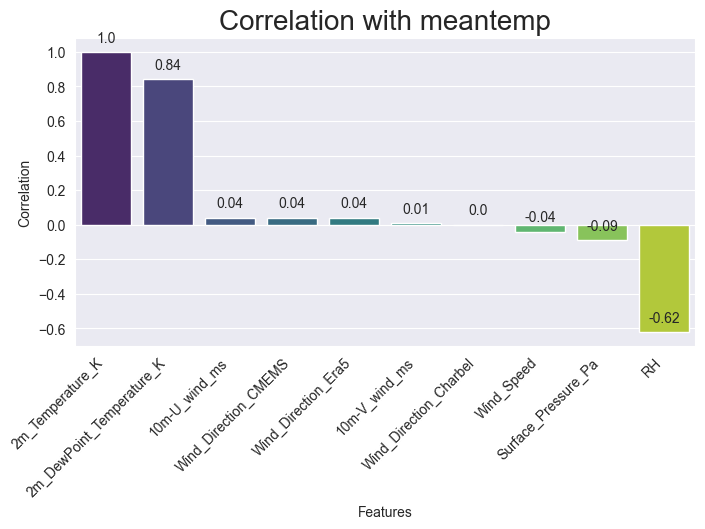

In [52]:
plt.figure(figsize=(8, 4))
sns.set_style('darkgrid')

correlation_matrix = round(data_prunay.corr(), 2)

correlation_with_trgt = correlation_matrix['2m_Temperature_K'].sort_values(ascending=False)

ax = sns.barplot(x=correlation_with_trgt.index, y=correlation_with_trgt, palette='viridis')

plt.title('Correlation with meantemp', size= 20)
plt.xlabel('Features')
plt.ylabel('Correlation')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.show()

In [53]:
data_prunay = data_prunay[["2m_Temperature_K", "RH"]].copy()

In [54]:
data_prunay['2m_Temperature_C'] = data_prunay['2m_Temperature_K'] - 273.15
data_prunay.drop(['2m_Temperature_K'], axis=1, inplace=True)

In [55]:
data_prunay = data_prunay.resample('D').mean()

In [56]:
data_prunay.shape

(7103, 2)

In [57]:
dl_train_data_prunay, dl_val_data_prunay, dl_test_data_prunay = split_dataframe(data_prunay)

Train size : 4972
Val size : 1420
Test size : 711


In [58]:
dl_train_data_prunay

,RH,2m_Temperature_C
time,,
2006-01-01,98.540228,4.205977
2006-01-02,97.590548,3.846317
2006-01-03,97.849224,2.389316
2006-01-04,96.990512,0.774877
2006-01-05,96.744393,0.249098
...,...,...
2019-08-08,86.814751,22.202365
2019-08-09,92.293224,22.231662
2019-08-10,87.152592,21.144493


In [59]:
minmax_scaler_data_prunay = MinMaxScaler()  # scaler for humidity
target_transformer_data_prunay = MinMaxScaler()   # scaler for target (meantemp)

In [60]:
dl_train_data_prunay['2m_Temperature_C'] = target_transformer_data_prunay.fit_transform(dl_train_data_prunay[['2m_Temperature_C']]) # target
dl_train_data_prunay['RH'] = minmax_scaler_data_prunay.fit_transform(dl_train_data_prunay[['RH']]) # minmax for humidity

dl_val_data_prunay['2m_Temperature_C'] = target_transformer_data_prunay.transform(dl_val_data_prunay[['2m_Temperature_C']])
dl_val_data_prunay['RH'] = minmax_scaler_data_prunay.transform(dl_val_data_prunay[['RH']])

dl_test_data_prunay['2m_Temperature_C'] = target_transformer_data_prunay.transform(dl_test_data_prunay[['2m_Temperature_C']])
dl_test_data_prunay['RH'] = minmax_scaler_data_prunay.transform(dl_test_data_prunay[['RH']])

In [61]:
# Create sequences
sequence_length = 3 # Example sequence length (adjust based on your data and experimentation)
X_data_prunay_train, y_data_prunay_train = create_dataset(dl_train_data_prunay, dl_train_data_prunay['2m_Temperature_C'], sequence_length)
X_data_prunay_val, y_data_prunay_val = create_dataset(dl_val_data_prunay, dl_val_data_prunay['2m_Temperature_C'], sequence_length)
X_data_prunay_test, y_data_prunay_test = create_dataset(dl_test_data_prunay, dl_test_data_prunay['2m_Temperature_C'], sequence_length)

In [33]:
model_data_prunay, history_data_prunay, val_loss_data_prunay = build_and_train_bilstm(X_data_prunay_train, y_data_prunay_train, X_data_prunay_val, y_data_prunay_val, sequence_length , units=100, epochs=50, batch_size=8)



Epoch 1/50

622/622 [==============================] - 5s 3ms/step - loss: 0.0060 - val_loss: 0.0038
Epoch 2/50
622/622 [==============================] - 2s 2ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 3/50
622/622 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 4/50
622/622 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 5/50
622/622 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 6/50
622/622 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 7/50
622/622 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 8/50
622/622 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 9/50
622/622 [==============================] - 2s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/50
622/622 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0

'Validation Loss: 0.0023811841383576393'

In [34]:
model_data_prunay.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 200)               82400     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 82601 (322.66 KB)
Trainable params: 82601 (322.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


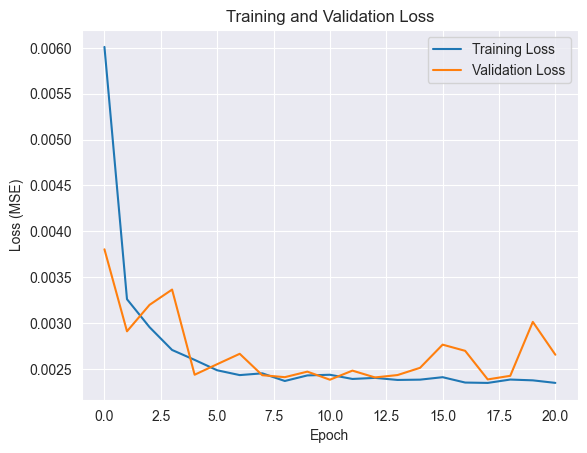

In [35]:
# Get training and validation losses from history
training_loss = history_data_prunay.history['loss']
validation_loss = history_data_prunay.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [36]:
# Make predictions data train
y_pred_inv, y_val_inv = predict_and_inverse_transform(model_data_prunay, X_data_prunay_val, y_data_prunay_val, target_transformer_data_prunay)

45/45 [==============================] - 1s 1ms/step


In [37]:
# Eavluate Model data train 
evaluate_model(y_val_inv, y_pred_inv)

MAE: 1.5472
RMSE: 2.0263
R2 Score: 0.9064


In [39]:
data_prunay

,RH,2m_Temperature_C
time,,
2006-01-01,98.540228,4.205977
2006-01-02,97.590548,3.846317
2006-01-03,97.849224,2.389316
2006-01-04,96.990512,0.774877
2006-01-05,96.744393,0.249098
...,...,...
2025-06-08,92.351952,14.433693
2025-06-09,91.292072,15.025831
2025-06-10,92.672336,16.870916


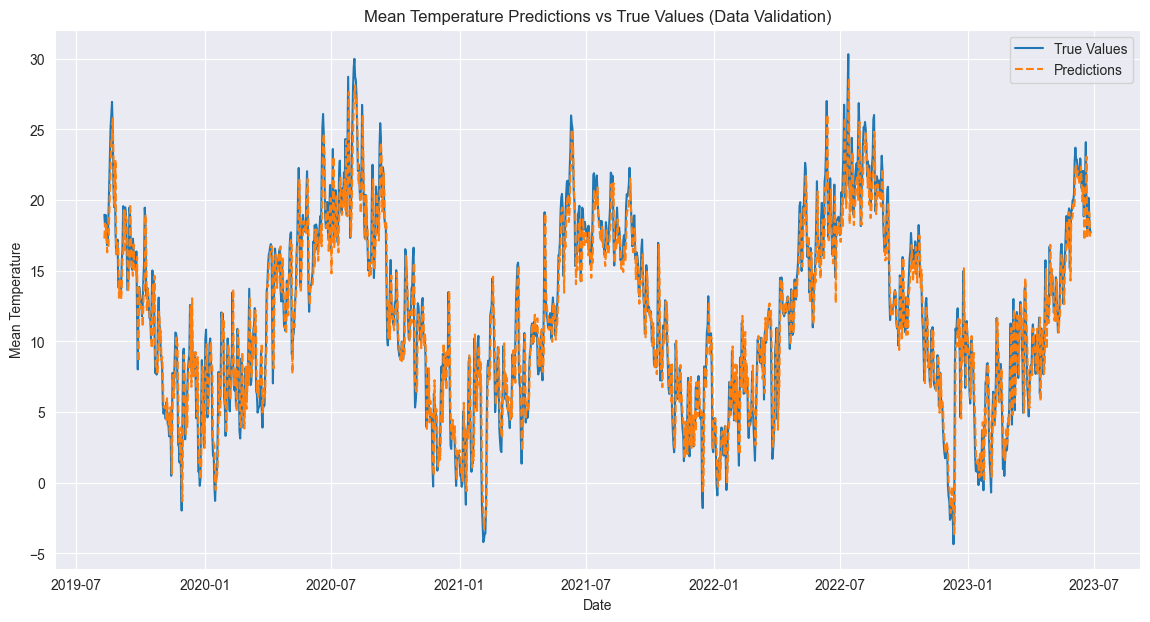

In [40]:
# Plot the results Data Validation
plt.figure(figsize=(14, 7))
plt.plot(data_prunay.index[len(y_data_prunay_train): len(y_data_prunay_train) + len(y_data_prunay_val)], y_val_inv, label='True Values')
plt.plot(data_prunay.index[len(y_data_prunay_train): len(y_data_prunay_train) + len(y_data_prunay_val)], y_pred_inv, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values (Data Validation)')
plt.legend()
plt.show()

In [41]:
# Make predictions data test
y_pred_inv_test, y_val_inv_test = predict_and_inverse_transform(model_data_prunay, X_data_prunay_test, y_data_prunay_test, target_transformer_data_prunay)

23/23 [==============================] - 0s 1ms/step


In [43]:
# Eavluate Model data train 
evaluate_model(y_val_inv_test, y_pred_inv_test)

MAE: 1.6332
RMSE: 2.1019
R2 Score: 0.8906


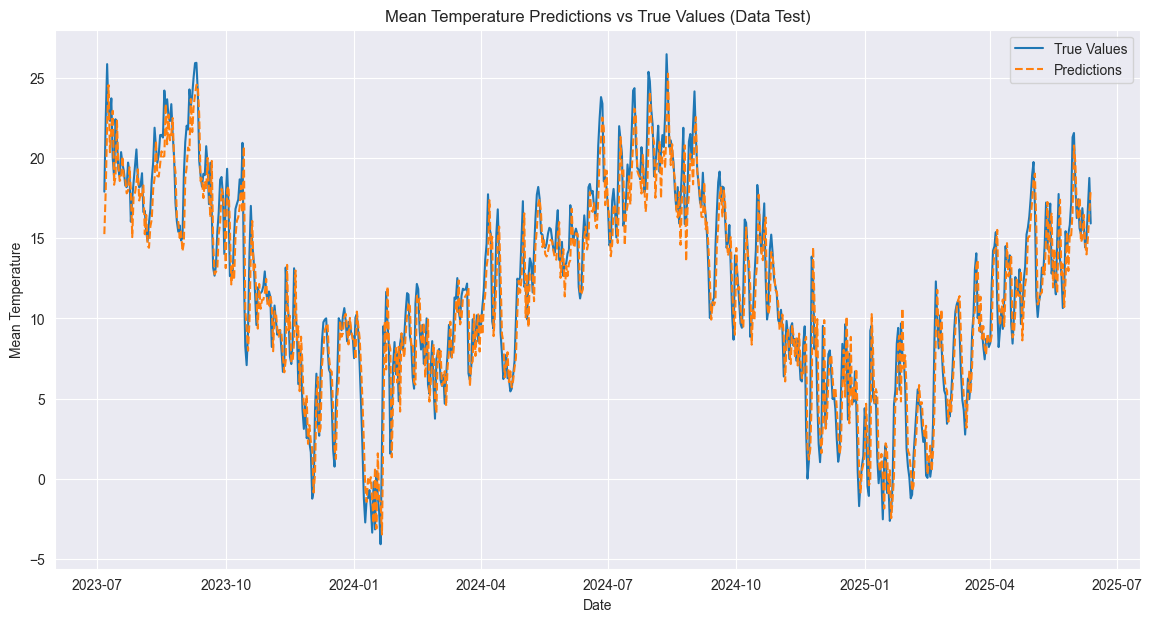

In [44]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data_prunay.index[-len(y_data_prunay_test):], y_val_inv_test, label='True Values')
plt.plot(data_prunay.index[-len(y_data_prunay_test):], y_pred_inv_test, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values (Data Test)')
plt.legend()
plt.show()

In [45]:
data_prunay

,RH,2m_Temperature_C
time,,
2006-01-01,98.540228,4.205977
2006-01-02,97.590548,3.846317
2006-01-03,97.849224,2.389316
2006-01-04,96.990512,0.774877
2006-01-05,96.744393,0.249098
...,...,...
2025-06-08,92.351952,14.433693
2025-06-09,91.292072,15.025831
2025-06-10,92.672336,16.870916


#### **Dataset Releve iButton Basilique Saint-Rémi**

In [46]:
data_basilique_2018_2019 = pd.read_excel('Releve iButton Basilique Saint Rémi/DATA_processing_iButton_2018_2019.xlsx',  index_col='Date Heure', parse_dates=True)
data_basilique_2018_2019.head()

,N1NTemp,N1ETemp,N1STemp,N1OTemp,S1NTemp,S1OTemp,N2STemp,N2OTemp,N2ETemp,N2NTemp,...,S2ETemp,S2NTemp,N2SHR,N2OHR,N2EHR,N2NHR,S2SHR,S2OHR,S2EHR,S2NHR
Date Heure,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:01,9.7,9.7,9.9,9.7,9.7,9.3,9.8,9.7,9.7,9.6,...,9.9,9.6,77.4,78.9,77.7,78.3,79.4,82.8,77.9,78.5
2018-01-01 01:00:01,9.1,9.7,9.4,9.4,9.2,8.9,9.5,9.0,9.4,9.3,...,9.7,9.4,76.8,81.7,77.9,78.5,81.0,92.2,78.6,78.9
2018-01-01 02:00:01,9.0,9.0,8.9,9.0,9.1,8.2,9.0,8.9,8.9,8.8,...,9.2,8.9,75.9,76.5,76.6,77.7,77.7,80.8,77.9,77.5
2018-01-01 03:00:01,8.5,9.0,9.1,8.9,8.6,8.8,9.0,8.8,8.9,8.9,...,9.1,8.9,76.3,77.5,76.5,76.9,78.0,79.4,77.9,76.7
2018-01-01 04:00:01,7.7,8.5,8.1,6.9,7.9,7.5,8.1,8.0,8.1,8.0,...,8.6,8.0,78.2,81.0,79.2,79.2,78.3,87.6,78.2,80.0


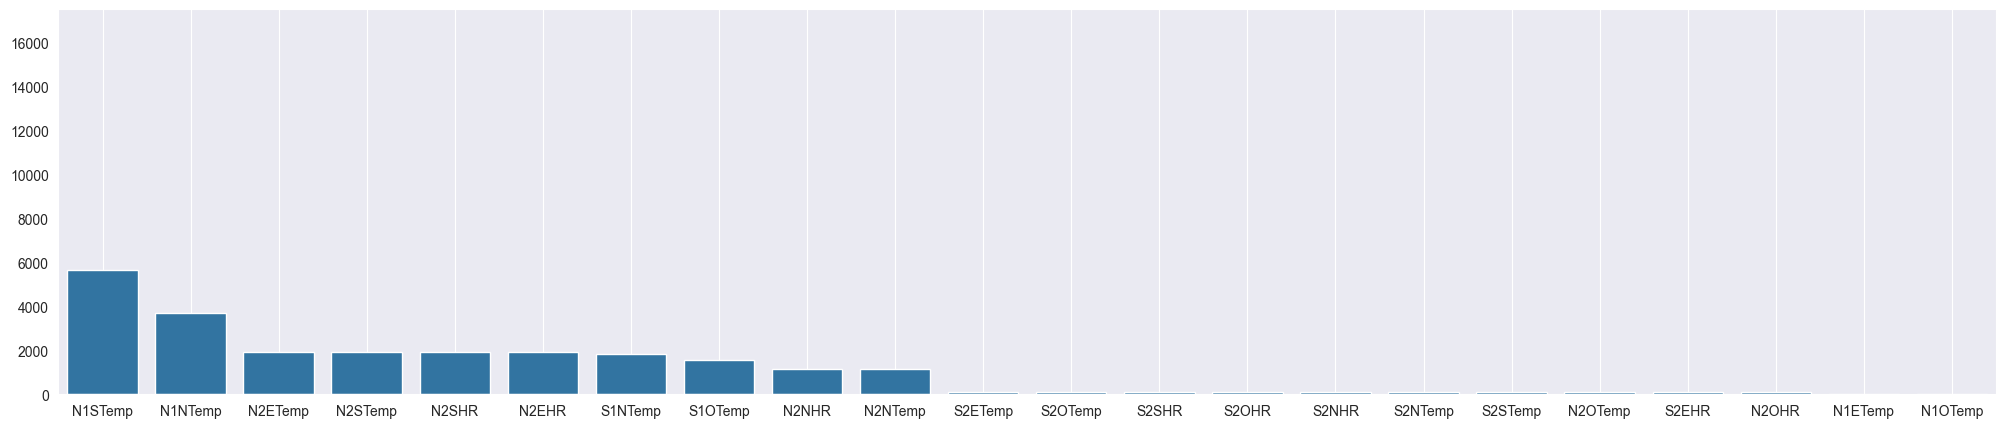

In [47]:
plt.figure(figsize=(25,5))
labels = data_basilique_2018_2019[Temp_HR].isnull().sum().sort_values(ascending=False).index.to_list()
sizes = data_basilique_2018_2019[Temp_HR].isnull().sum().sort_values(ascending=False).to_list()
sns.barplot(x=labels, y=sizes)
plt.grid()
plt.ylim((0.0, float(data_basilique_2018_2019.shape[0])))
plt.show()

In [48]:
data_bsr_2018_2019 = data_basilique_2018_2019.resample('D').mean().copy()
data_bsr_2018_2019 = data_bsr_2018_2019[["S2STemp", "S2SHR"]]
data_bsr_2018_2019 = data_bsr_2018_2019.interpolate(method='linear') ## Pour remplacer les valeurs NAN DU 2018-06-10, 2018-06-11, 2018-06-12, 2018-06-13
data_bsr_2018_2019

,S2STemp,S2SHR
Date Heure,,
2018-01-01,7.400000,91.754167
2018-01-02,6.787500,96.329167
2018-01-03,10.229167,82.954167
2018-01-04,10.091667,94.233333
2018-01-05,9.525000,90.345833
...,...,...
2019-12-27,8.545833,103.325000
2019-12-28,5.887500,93.720833
2019-12-29,4.000000,86.333333


In [49]:
dl_train_data_bsr, dl_val_data_bsr, dl_test_data_bsr = split_dataframe(data_bsr_2018_2019)

Train size : 510
Val size : 146
Test size : 74


In [50]:
minmax_scaler_data_bsr = MinMaxScaler()  # scaler for humidity
target_transformer_data_bsr = MinMaxScaler()   # scaler for target (meantemp)

In [51]:
dl_train_data_bsr['S2STemp'] = target_transformer_data_bsr.fit_transform(dl_train_data_bsr[['S2STemp']]) # target
dl_train_data_bsr['S2SHR'] = minmax_scaler_data_bsr.fit_transform(dl_train_data_bsr[['S2SHR']]) # minmax for humidity

dl_val_data_bsr['S2STemp'] = target_transformer_data_bsr.transform(dl_val_data_bsr[['S2STemp']])
dl_val_data_bsr['S2SHR'] = minmax_scaler_data_bsr.transform(dl_val_data_bsr[['S2SHR']])

dl_test_data_bsr['S2STemp'] = target_transformer_data_bsr.transform(dl_test_data_bsr[['S2STemp']])
dl_test_data_bsr['S2SHR'] = minmax_scaler_data_bsr.transform(dl_test_data_bsr[['S2SHR']])

In [52]:
# Create sequences
sequence_length = 3  # Example sequence length (adjust based on your data and experimentation)
X_data_bsr_train, y_data_bsr_train = create_dataset(dl_train_data_bsr, dl_train_data_bsr['S2STemp'], sequence_length)
X_data_bsr_val, y_data_bsr_val = create_dataset(dl_val_data_bsr, dl_val_data_bsr['S2STemp'], sequence_length)
X_data_bsr_test, y_data_bsr_test = create_dataset(dl_test_data_bsr, dl_test_data_bsr['S2STemp'], sequence_length)

In [53]:
model_data_bsr, history_data_bsr, val_loss_data_bsr = build_and_train_bilstm(X_data_bsr_train, y_data_bsr_train, X_data_bsr_val, y_data_bsr_val, sequence_length , units=100, epochs=30, batch_size=1)

Epoch 1/30
507/507 [==============================] - 4s 3ms/step - loss: 0.0156 - val_loss: 0.0119
Epoch 2/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0057
Epoch 3/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 4/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 5/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0069 - val_loss: 0.0092
Epoch 6/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 7/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0068
Epoch 8/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 9/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 10/30
507/507 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0048

'Validation Loss: 0.00459790974855423'

In [54]:
model_data_bsr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 200)               82400     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 82601 (322.66 KB)
Trainable params: 82601 (322.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


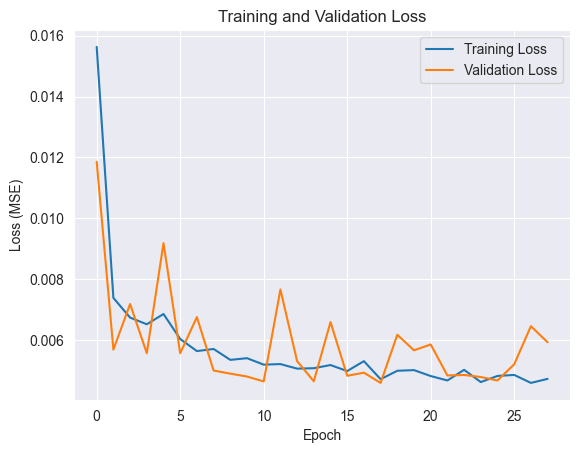

In [55]:
# Get training and validation losses from history
training_loss = history_data_bsr.history['loss']
validation_loss = history_data_bsr.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [56]:
# Make predictions data train
y_pred_data_bsr_inv, y_val_data_bsr_inv = predict_and_inverse_transform(model_data_bsr, X_data_bsr_val, y_data_bsr_val, target_transformer_data_bsr)

5/5 [==============================] - 0s 2ms/step


In [57]:
# Eavluate Model data train 
evaluate_model(y_val_data_bsr_inv, y_pred_data_bsr_inv)

MAE: 1.9664
RMSE: 2.4730
R2 Score: 0.7563


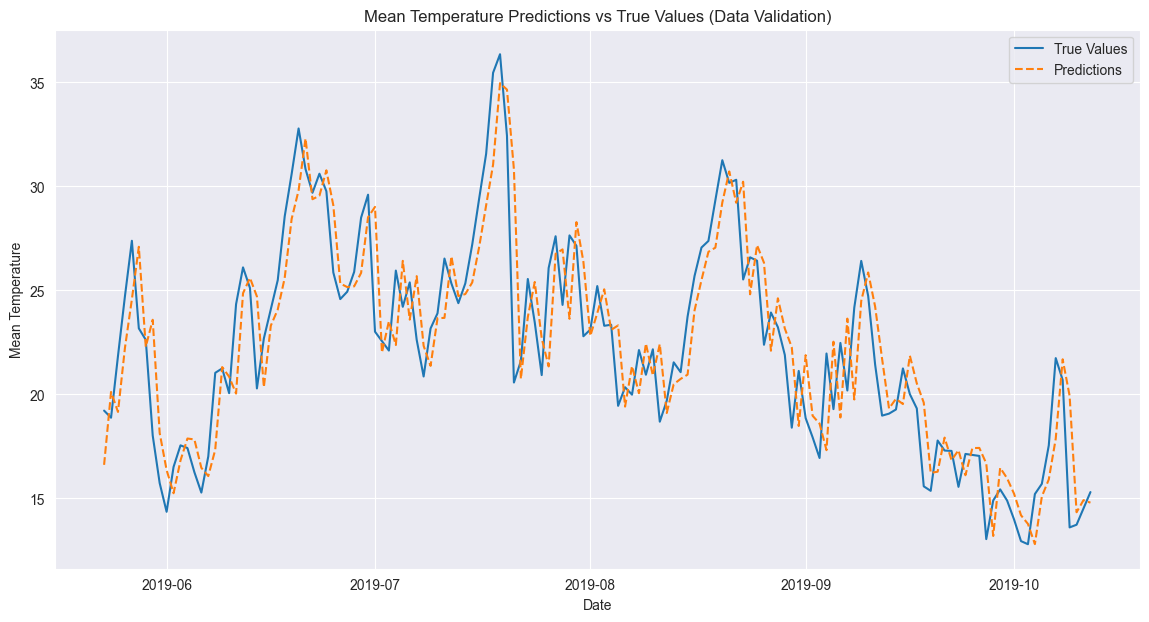

In [62]:
# Plot the results Data Validation
plt.figure(figsize=(14, 7))
plt.plot(data_bsr_2018_2019.index[len(y_data_bsr_train): len(y_data_bsr_train) + len(y_data_bsr_val)], y_val_data_bsr_inv, label='True Values')
plt.plot(data_bsr_2018_2019.index[len(y_data_bsr_train): len(y_data_bsr_train) + len(y_data_bsr_val)], y_pred_data_bsr_inv, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values (Data Validation)')
plt.legend()
plt.show()

In [60]:
# Make predictions data test
y_pred_inv_data_bsr_test, y_test_inv_data_bsr_test = predict_and_inverse_transform(model_data_bsr, X_data_bsr_test, y_data_bsr_test, target_transformer_data_bsr)

3/3 [==============================] - 0s 4ms/step


In [61]:
# Eavluate Model data test
evaluate_model(y_test_inv_data_bsr_test, y_pred_inv_data_bsr_test)

MAE: 1.8390
RMSE: 2.2524
R2 Score: 0.5375


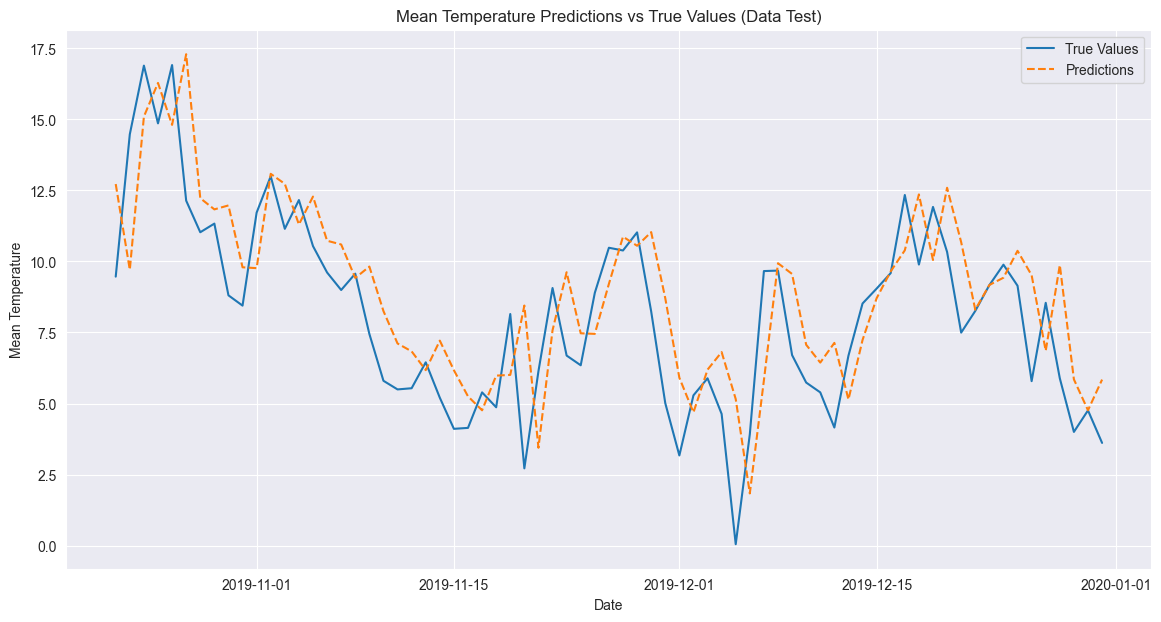

In [63]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data_bsr_2018_2019.index[-len(y_data_bsr_test):], y_test_inv_data_bsr_test, label='True Values')
plt.plot(data_bsr_2018_2019.index[-len(y_data_bsr_test):], y_pred_inv_data_bsr_test, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values (Data Test)')
plt.legend()
plt.show()

#### **Correction des biais des données du DRIAS**

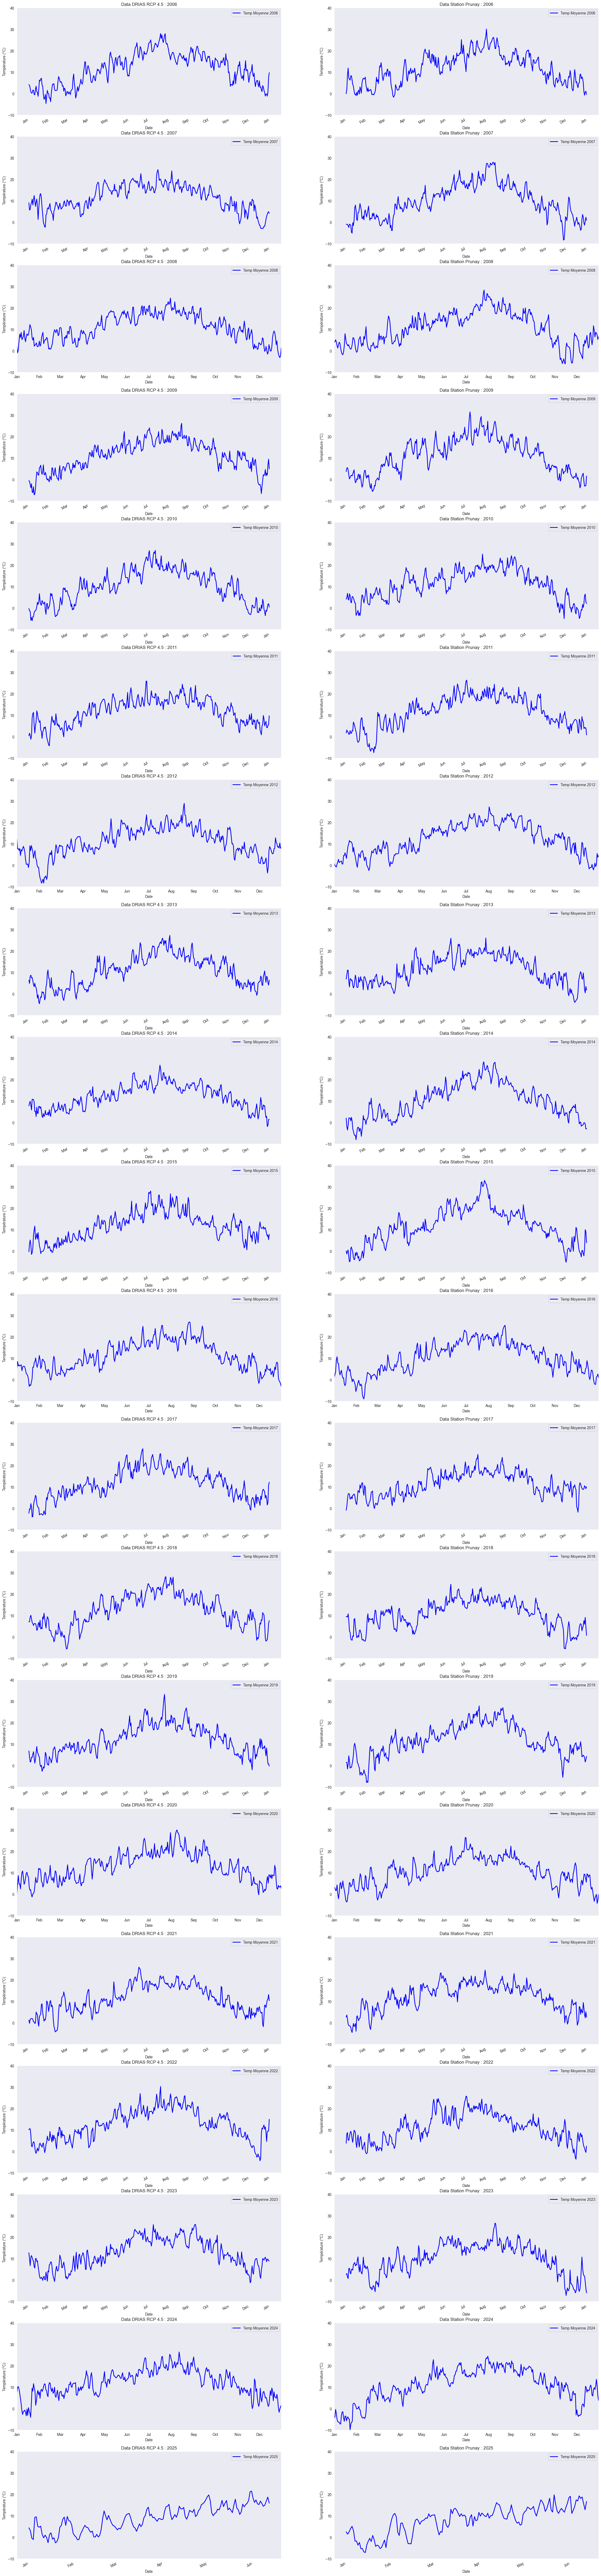

In [ ]:
temp_mean_max_min(data_rcp_4_5_, data_prunay, "Data DRIAS RCP 4.5", "Data Station Prunay")

In [88]:
# Comparaison des performances entre les RCP
rcp_compare = {
    'RCP 2.6': evaluate_model(data_prunay["2m_Temperature_C"], data_rcp_2_6_["tasAdjust"]),
    'RCP 4.5': evaluate_model(data_prunay["2m_Temperature_C"], data_rcp_4_5_["tasAdjust"]),
    'RCP 8.5': evaluate_model(data_prunay["2m_Temperature_C"], data_rcp_8_5_["tasAdjust"])
}

# Mettre dans un DataFrame avec MAE, RMSE, R2 en index
rcp_compare = pd.DataFrame(rcp_compare, index=['MAE', 'RMSE', 'R2'])

print()
print()
# Affichage clair
print(rcp_compare.T.round(3))


MAE: 3.9803
RMSE: 5.0332
R2 Score: 0.4318
MAE: 4.1301
RMSE: 5.1779
R2 Score: 0.3987
MAE: 3.9787
RMSE: 5.0529
R2 Score: 0.4274


           MAE   RMSE     R2
RCP 2.6  3.980  5.033  0.432
RCP 4.5  4.130  5.178  0.399
RCP 8.5  3.979  5.053  0.427
